# Intro to the model   
C:\pest\A\A1\reimagined-adventure\00_Beta_tutorials\02_Beta_part0_02_intro_to_freyberg_model\00_Hunt_Freyberg_Article.pdf

C:\pest\A\A1\reimagined-adventure\a00_RMG_Freyberg.xlsx

In [2]:
import os
import shutil
import platform
import pandas as pd
import matplotlib.pyplot as plt
import sys
# sys.path.append(os.path.join("..", "..", "dependencies"))
import flopy
import pyemu
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
sys.path.insert(0,"..")
import herebedragons as hbd

ModuleNotFoundError: No module named 'flopy'

In [ ]:
org_ws = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')
sim_ws = os.path.join('freyberg_mf6')

In [ ]:
# remove existing folder  ------______________---- New folder
if os.path.exists(sim_ws):
    shutil.rmtree(sim_ws)

In [48]:
# copy the original model folder across ---------- executables 
shutil.copytree(org_ws, sim_ws)

'freyberg_mf6'

In [49]:
# bring over the correct binaries
hbd.prep_bins(sim_ws)

## Flopy | MODFLOW 6 | PYemu

In [54]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=sim_ws, verbosity_level=0)

# load flow model
gwf = sim.get_model()

# run the model
#sim.run_simulation()
pyemu.os_utils.run("mf6",cwd=sim_ws)

### Model Domain, BCs and Properties

In [56]:
dis = gwf.dis
print(f'layers:{dis.nlay.get_data()} nrows:{dis.nrow.get_data()} columns:{dis.ncol.get_data()}')

layers:1 nrows:40 columns:20


In [ ]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
# plot
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
mm.plot_inactive()
mm.plot_grid()
mm.plot_bc('ghb')
mm.plot_bc('sfr')
mm.plot_bc('wel');

In [52]:
# -------------------------------------------------  K   ---------------------------
for lay in range(gwf.dis.nlay.array):
    print(f'K in layer {lay+1}:', "{:10.1f}".format(gwf.npf.k.get_data(lay).mean()))

K in layer 1:       11.1


In [ ]:
gwf.npf.k.plot(colorbar=True, mflay=0);

Surface topography and the bottom elevation are not uniform (see plots below), with a top and bottom elevation of 32.5m and 30m, respectively.

In [ ]:
# plot model top
gwf.dis.top.plot(colorbar=True, masked_values=[-1049.99])

# plot bottom of bottom layer
gwf.dis.botm.plot(colorbar=True);

### Time Discretisation

## Observation Data

The following field data are available as "observations" for the purposes of history matching:
 - surface-water flow at the terminal reach (stress period 2 to 13);
 - groundwater levels at two sites (stress period 2 to 13); 

"Measured" data was generated using the same model, but with higher spatial and temporal resolution (i.e. a finer grid and daily stress periods) and randomly generated parameters.

In [67]:
obs_data = pd.read_csv(os.path.join('..','..','models','daily_freyberg_mf6_truth','obs_data.csv'))
obs_data.head()
# C:\pest\A\A1\reimagined-adventure\models\daily_freyberg_mf6_truth\obs_data.csv

,site,time,value
0,GAGE-1,3652.5,3405.652701
1,GAGE-1,3653.5,2461.823847
2,GAGE-1,3654.5,3439.303917
3,GAGE-1,3655.5,3197.206746
4,GAGE-1,3656.5,2625.301281


In [66]:
obs_data = pd.read_csv(os.path.join('..','..','models','daily_freyberg_mf6_truth','obs_data.csv'))
obs_data = obs_data.pivot(index='time', columns='site', values='value')
obs_data.head()
# C:\pest\A\A1\reimagined-adventure\models\daily_freyberg_mf6_truth\obs_data.csv

site,GAGE-1,TRGW-0-26-6,TRGW-0-3-8,TRGW-2-26-6,TRGW-2-3-8
time,,,,,
3652.5,3405.652701,37.474939,38.063501,37.265657,38.271754
3653.5,2461.823847,37.386635,38.036154,37.300383,37.918392
3654.5,3439.303917,37.512783,37.996237,37.422833,37.942242
3655.5,3197.206746,37.363104,37.995715,37.408999,38.056998
3656.5,2625.301281,37.091275,38.127423,37.436713,37.909742


Model simulated counterparts to these observations are recorded in external CSV files. Let's take a look:

In [68]:
# check the output csv file names
for i in gwf.obs:
    print(i.output.obs_names)

['sfr.csv']
['heads.csv']


We can read the `sfr.csv` output file, and inspect the values:

In [69]:
sfr_obs = pd.read_csv(os.path.join(sim_ws, 'sfr.csv'))
sfr_obs.head()

,time,HEADWATER,TAILWATER,GAGE-1
0,3652.5,-1271.609373,-934.744886,2675.694849
1,3683.5,-1188.261301,-903.583105,2561.700004
2,3712.5,-1278.176409,-975.062935,2720.180988
3,3743.5,-1442.004051,-1100.483634,3005.022456
4,3773.5,-1576.905331,-1201.101468,3237.266916


# Nope
Simulated values for surface-water flow at the terminal reach are recorded in the "GAGE1" column: (?)

In [ ]:
site = 'GAGE-1'
fig,ax=plt.subplots(1,1)
obs_data.plot(y=site, ax=ax, label='measured')
sfr_obs.plot(x='time', y=site, ax=ax, label='modelled')
ax.set_title(site);

Simulated groundwater levels are recorded in the "heads.csv" file. Several monitoring sites are simulated, however there is measured data for a only a few of these. 

The sites for which "measured data" are available are named:
 - TRGW-0-26-6
 - TRGW-0-3-8
## The site naming convention is: "TRGW-layer-row-column".

In [ ]:
hds_obs = pd.read_csv(os.path.join(sim_ws, 'heads.csv'))
hds_obs.head()

## time series
Let's make a quick plot of time series of simulated groundwater levels at both measured sites:

KeyError: 'TRGW-0-26-6'

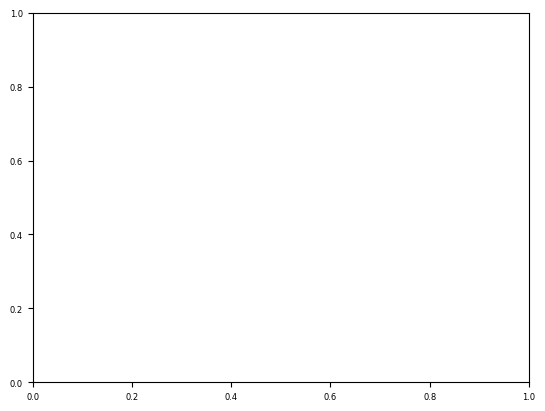

In [81]:
for site in ['TRGW-0-26-6','TRGW-0-3-8']:
    fig,ax=plt.subplots(1,1)
    obs_data.plot(y=site, ax=ax, label='measured')
    hds_obs.plot(x='time', y=site, ax=ax, label='modelled')
    ax.set_title(site);

Whilst we are at it, lets just make a plot of the spatial distribution of simulated heads:

In [ ]:
hdobj = gwf.output.head()
times = hdobj.get_times()
hdobj.plot(mflay=0, colorbar=True, totim=times[-1], masked_values=[1e30]);

## Forecasts

Three model simulated outputs are included as forecast "observations". These represent predictions of management interest for our imaginary case. Simulated forecasts are:
 - aggregated surface-water/grounwdater exchange for reaches 1-20 (recorded under "headwater" in the sfr.csv file) during stress period 22;
 - aggregated surface-water/grounwdater exchange for reaches 21-40 (recorded under "tailwater" in the sfr.csv file) during stress period 22;
 - groundwater level at TRGW_0_9_1 at the end of stress period 22;
 - travel time for a particle released in the north-west of the domain to exit the model domain.

These forecasts were selected to represent model outputs that are informed in varying degrees by the history matching data. Throughout the tutorials we will compare our simulated forecast and uncertainty against "true" values obtained by running the same model with which we generated "measured" observation data. 